In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow-gpu

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import nltk
import sys
from  tensorflow.keras.preprocessing import text
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from sklearn import feature_selection, feature_extraction, model_selection, preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,roc_curve, auc, precision_score, recall_score, classification_report
import gensim
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/all_fake_real_news.csv')

In [ ]:
data = data.sample(frac=1)

### Word embedding

In [ ]:
# We use a pretrained word2vec google news model with 300 dimentions to describe each of the word
pre_train = gensim_api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN")
tokenizer.fit_on_texts(data['text'])
dic_vocabulary = tokenizer.word_index

# create sequence
word_seq= tokenizer.texts_to_sequences(data['text'])

# padding sequence
padded = kprocessing.sequence.pad_sequences(word_seq, 
                    maxlen=100, padding="post", truncating="post")

In [ ]:
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

X_train = padded[:split_n]
y_train = data['class'].values[:split_n]
X_test = padded[split_n:]
y_test = data['class'].values[split_n:]

#### Split Train/Test set

In [ ]:
# # split dataset
# news_train, news_test = model_selection.train_test_split(data, test_size=0.2)
# # get target
# y_train = news_train["class"].values
# y_test = news_test["class"].values

In [ ]:
# start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    # update the row with vector
    try:
        embeddings[idx] =  pre_train[word]
    # if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
embeddings.shape

(20042, 300)

In [ ]:
X_train.shape

(7744, 100)

In [ ]:
embedding[1]

NameError: ignored

### Build the architecture

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,)),
    tf.keras.layers.Embedding(embeddings.shape[0], 300, trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    #tf.keras.layers.LSTM(20, return_sequences=True),
    #tf.keras.layers.LSTM(20),
    #tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    #tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # tf.keras.layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, return_sequences=True)),
    # tf.keras.layers.Bidirectional(layers.LSTM(units=15, dropout=0.2)),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(1, activation='sigmoid')

])

In [ ]:
# Model Summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 300)          6012600   
_________________________________________________________________
dropout_15 (Dropout)         (None, 100, 300)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 96, 64)            96064     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 24, 512)           33280     
_________________________________________________________________
dense_25 (Dense)             (None, 24, 256)           131328    
_________________________________________________________________
dense_26 (Dense)             (None, 24, 1)            

In [ ]:
# # encode y
# dic_y_mapping = {n:label for n,label in 
#                  enumerate(np.unique(y_train))}
# inverse_dic = {v:k for k,v in dic_y_mapping.items()}
# y_train = np.array([inverse_dic[y] for y in y_train])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=[X_test, y_test])

print("Training Complete")

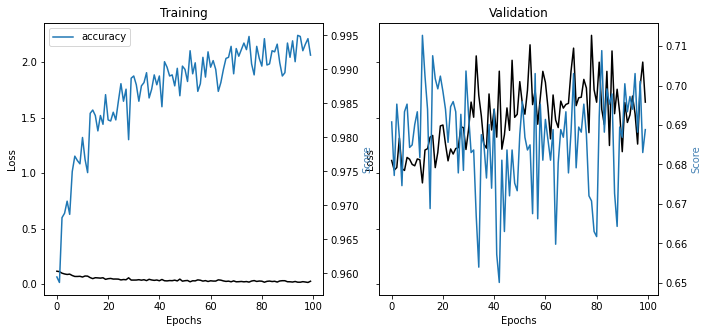

In [ ]:
metrics = [k for k in history.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(11,5))
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(history.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')

for metric in metrics:
    ax11.plot(history.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(history.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(history.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

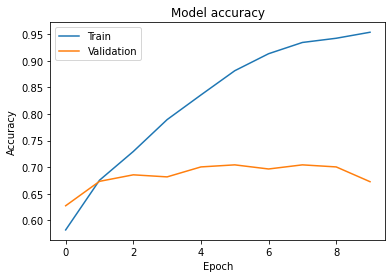

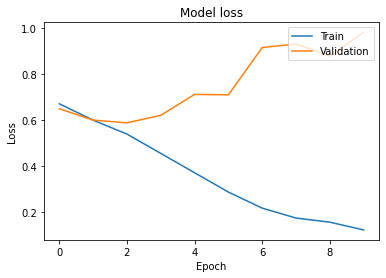

In [ ]:
# Visualize the training process:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Predict the test set
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [ ]:
print(predicted)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Accuracy: 0.52
Precision 0.0
Recall 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


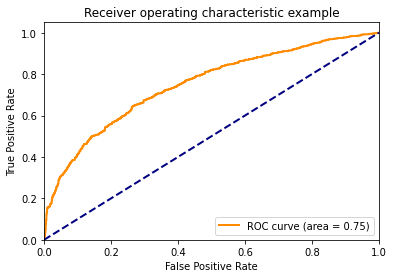

In [ ]:
# Overall performance of the gpt-2-detector
fpr = dict()
tpr = dict()
roc_auc = dict()

accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)

print("Accuracy:",  round(accuracy,2))
print("Precision", round(precision,2))
print("Recall", round(recall,2))

fpr, tpr, _ = roc_curve(y_test, predicted_prob)
roc_auc = auc(fpr, tpr)
    
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
# Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, predicted)
auc = roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()